In [18]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForCausalLM, BertConfig
import sys
import transformers.models.bert.modeling_bert
import builtins

class BlockImport:
    def __init__(self, *blocked):
        self.blocked = set(blocked)

    def __enter__(self):
        self._orig_import = builtins.__import__

        def fake_import(name, *args, **kwargs):
            if any(name == b or name.startswith(b + ".") for b in self.blocked):
                raise ImportError(f"Blocked import of {name}")
            return self._orig_import(name, *args, **kwargs)

        builtins.__import__ = fake_import

    def __exit__(self, exc_type, exc_value, traceback):
        builtins.__import__ = self._orig_import


class dnalm_embedding_extraction():
    def __init__(self, model_class, model_name, device):
        self.model_class = model_class
        if model_class=="DNABERT2":
            self.model_name = f"zhihan1996/{model_name}"
            # with NoModule("triton"):
            # with NoTriton():
            with BlockImport("triton"):
                self.tokenizer = AutoTokenizer.from_pretrained(
                    self.model_name, trust_remote_code=True
                )
                config = BertConfig.from_pretrained(self.model_name, trust_remote_code=True)
                self.model = AutoModelForMaskedLM.from_pretrained(self.model_name, config=config, trust_remote_code=True)
                self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="HyenaDNA":
            self.model_name = f"LongSafari/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True, padding_side="right")
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=True)

        elif model_class=="Nucleotide Transformer":
            self.model_name = f"InstaDeepAI/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModelForMaskedLM.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="Caduceus":
            self.model_name = f"kuleshov-group/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True, padding_side="right")
            self.model = AutoModelForMaskedLM.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="Mistral":
            self.model_name = f"RaphaelMourad/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        elif model_class=="GENA-LM":
            self.model_name = f"AIRI-Institute/{model_name}"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModel.from_pretrained(self.model_name, trust_remote_code=True)
            self.mask_token = self.tokenizer.mask_token_id
        else:
          print("Model not supported.")
        self.device = device
        self.model.to(self.device)
        self.model.eval()


    @property
    def start_token(self):
        if self.model_class=="HyenaDNA":
            return None
        elif self.model_class=="DNABERT2":
            return 1
        elif self.model_class=="Nucleotide Transformer":
            return 3
        elif self.model_class=="Caduceus":
            return None
        elif self.model_class=="Mistral":
            return 1
        elif self.model_class=="GENA-LM":
            return 1

    @property
    def end_token(self):
        if self.model_class=="HyenaDNA":
            return 1
        elif self.model_class=="DNABERT2":
            return 2
        elif self.model_class=="Nucleotide Transformer":
            return None
        elif self.model_class=="Caduceus":
            return 1
        elif self.model_class=="Mistral":
            return 2
        elif self.model_class=="GENA-LM":
            return 2

    def get_embedding(self, sequences, batch_size):
        embeddings = []
        for i in range(0, len(sequences), batch_size):
            # if i%50000==0:
            #     print(i)
            batch = sequences[i:min(i+batch_size, len(sequences))]

            if self.model_class=="Nucleotide Transformer":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="Mistral":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]

                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="HyenaDNA":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]

                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="DNABERT2":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                # !!! due to the bug in its code, DNABERT2 can only return the last hidden layer
                hidden = torch_outs.hidden_states
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="Caduceus":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            elif self.model_class=="GENA-LM":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                        attention_mask=attention_mask,
                        output_hidden_states=True,
                        return_dict=True,
                    )

                clip_mask = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(clip_mask.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))
                if attention_mask is not None:
                    clip_mask = clip_mask * attention_mask

                hidden = torch_outs.hidden_states[-1]
                mask = clip_mask.unsqueeze(-1)
                summed = (hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                mean_embeddings = summed / counts

            embeddings.append(mean_embeddings.cpu().numpy())
        return np.vstack(embeddings)


    def get_likelihood(self, sequences, batch_size):
        """
        Compute log-likelihoods of sequences.
        Returns: numpy array of log-likelihoods (one per sequence)
        """
        import torch.nn.functional as F

        likelihoods = []

        for i in range(0, len(sequences), batch_size):
            # if i % 50000 == 0:
            #     print(i)
            batch = sequences[i:min(i+batch_size, len(sequences))]

            if self.model_class == "Nucleotide Transformer":

                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)

            elif self.model_class == "Mistral":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                    )
                    logits = torch_outs.logits.swapaxes(1, 2)
                    lls = torch.zeros(tokens.shape[:2], device=self.device)
                    lls[:,1:] = -F.cross_entropy(logits[:,:,:-1], tokens[:,1:], reduction="none")

                clip_mask = torch.zeros_like(lls)
                for i in range(lls.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))

                seq_likelihoods = (lls * clip_mask).sum(1).numpy(force=True)

            elif self.model_class == "HyenaDNA":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)

                with torch.no_grad():
                    torch_outs = self.model(
                        tokens,
                    )
                    logits = torch_outs.logits.swapaxes(1, 2)
                    lls = torch.zeros(tokens.shape[:2], device=self.device)
                    lls[:,1:] = -F.cross_entropy(logits[:,:,:-1], tokens[:,1:], reduction="none")

                clip_mask = torch.zeros_like(lls)
                for i in range(lls.shape[1]):
                    clip_mask[:,i] = ((i >= starts) & (i < ends))

                seq_likelihoods = (lls * clip_mask).sum(1).numpy(force=True)

            elif self.model_class == "DNABERT2":

                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)

            elif self.model_class == "Caduceus":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)
            elif self.model_class == "GENA-LM":
                encoded = self.tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True)
                tokens = encoded["input_ids"]
                attention_mask = encoded.get("attention_mask")
                if self.start_token is not None:
                    starts = torch.where(tokens == self.start_token)[1] + 1
                else:
                    starts = 0
                if self.end_token is not None:
                    ends = torch.where(tokens == self.end_token)[1]
                else:
                    ends = attention_mask.sum(dim=1)

                tokens = tokens.to(device=self.device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device=self.device)
                lls = torch.zeros(tokens.shape[:2], device=self.device)
                for i in range(tokens.shape[1]):
                    clip_mask = ((i >= starts) & (i < ends)).to(device=self.device)
                    masked_tokens = tokens.clone()
                    masked_tokens[:,i,...] = self.mask_token
                    with torch.no_grad():
                        torch_outs = self.model(
                            masked_tokens,
                            attention_mask=attention_mask,
                        )
                        logits = torch_outs.logits.swapaxes(1, 2)
                        tmp = -F.cross_entropy(logits, tokens, reduction="none")
                        lls[:,i] = tmp[:,i] * clip_mask

                seq_likelihoods = lls.sum(dim=1).numpy(force=True)

            likelihoods.append(seq_likelihoods)

        return np.concatenate(likelihoods)

In [2]:
# def MLP model
import torch
import torch.nn as nn

# Define the MLP model for Binary Classification
class MLPBinary(nn.Module):
    def __init__(self, input_size):
        super(MLPBinary, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128) # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)   # Output layer for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x) # No sigmoid here, as BCEWithLogitsLoss will be used
        return x

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
from sklearn.decomposition import PCA # Import PCA

def EP_pair_identification(df, embedding_extractor, feature_sets):

    df['enhancer_embedding_mean'] = list(embedding_extractor.get_embedding(sequences=df["enhancer_seq"].tolist(), batch_size=10))
    df['promoter_embedding_mean'] = list(embedding_extractor.get_embedding(sequences=df["promoter_seq"].tolist(), batch_size=10))

    colors = ["teal", "orange", "crimson", "blue"]#, "purple"]
    results = []

    plt.figure(figsize=(7, 6))

    for (label, feats_orig), color in zip(feature_sets.items(), colors):
        feats = list(feats_orig)  # <-- copy, don’t mutate original
        feat_mat = []

        if "embeddings" in feats:
            E = np.vstack(df["enhancer_embedding_mean"].to_numpy())
            P = np.vstack(df["promoter_embedding_mean"].to_numpy())

            # # Apply PCA to reduce dimension to 50
            # combined_embeddings = np.hstack([E, P])
            # pca = PCA(n_components=50)
            # reduced_embeddings = pca.fit_transform(combined_embeddings)
            # feat_mat.append(reduced_embeddings)

            feat_mat.append(np.hstack([E, P]))

            feats.remove("embeddings")

        for feat in feats:
            feat_mat.append(df[feat].to_numpy().reshape(-1, 1))

        X = np.hstack(feat_mat).astype(np.float32)
        y = df["Significant"].astype(int).values

        # train/val split (stratified)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # # scale inputs
        # scaler = StandardScaler()
        # X_train = scaler.fit_transform(X_train)
        # X_test  = scaler.transform(X_test)

        # tensors
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_train_t = torch.from_numpy(X_train).float().to(device)
        y_train_t = torch.from_numpy(y_train).float().reshape(-1, 1).to(device)
        X_test_t  = torch.from_numpy(X_test).float().to(device)

        # model: small, regularized
        input_size = X_train.shape[1]
        model = MLPBinary(input_size).to(device)  # ensure this has Dropout/BatchNorm or is small

        # class imbalance
        neg, pos = np.bincount(y_train)
        pos_weight = torch.tensor(neg / max(pos, 1), dtype=torch.float, device=device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

        # early stopping on val AUPRC
        best_ap, patience, wait = -np.inf, 20, 0
        num_epochs = 10000
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            logits = model(X_train_t)
            loss = criterion(logits, y_train_t)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            probs = torch.sigmoid(model(X_test_t)).cpu().numpy().ravel()

        precision, recall, _ = precision_recall_curve(y_test, probs)
        ap = average_precision_score(y_test, probs)
        results.append((label, ap))
        plt.plot(recall, precision, color=color, lw=2, label=f"{label} (AUPRC={ap:.3f})")

        y_pred = (probs >= 0.5).astype(int)
        prec_cls = precision_score(y_test, y_pred, zero_division=0)
        rec_cls  = recall_score(y_test, y_pred, zero_division=0)
        f1_cls   = f1_score(y_test, y_pred, zero_division=0)
        print(embedding_extractor.model_class)
        print(f"  {label}:")
        print(f"  Precision: {prec_cls:.3f}")
        print(f"  Recall   : {rec_cls:.3f}")
        print(f"  F1 score : {f1_cls:.3f}\n")

    # baseline
    positive_rate = y_test.mean()
    plt.hlines(positive_rate, 0, 1, color="gray", linestyle="--", label=f"Random (p={positive_rate:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curves for {embedding_extractor.model_class} Embedding")
    plt.legend(); plt.tight_layout(); plt.show()


In [4]:
import pandas as pd

file_path = "/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/EP Pair Evaluation/accessary_files/processed_crispri_data.csv"
df = pd.read_csv(file_path)

feature_sets = {
    "Model 1: Embedding only": ["embeddings"],
    "Model 2: + Distance + Enhancer length": ["distanceToTSS_abs", "enhancer_length", "embeddings"],
    "Model 3: + Chromatin features": [
        "distanceToTSS_abs",
        "enhancer_length",
        "H3K27ac.RPM",
        "DHS.RPM",
        "CTCF_peak_overlap",
        "H3K27me3_peak_overlap",
        "embeddings"
    ],
    # "Model 5: - Embedding": [
    #     "distanceToTSS_abs",
    #     "enhancer_length",
    #     "H3K27ac.RPM",
    #     "DHS.RPM",
    #     "CTCF_peak_overlap",
    #     "H3K27me3_peak_overlap"
    # ],
}

df["distanceToTSS_abs"] = df["distanceToTSS"].abs()
df["enhancer_length"] = df["chromEnd"] - df["chromStart"]

In [19]:
## Note:
## Mistral-DNA-v1-1.6B-hg38 not available on HuggingFace anymore

embedding_extractor_hyenaDNA = dnalm_embedding_extraction(model_class="HyenaDNA", model_name="hyenadna-large-1m-seqlen-hf", device=torch.device("cuda"))
embedding_extractor_mistral = dnalm_embedding_extraction(model_class="Mistral", model_name="Mistral-DNA-v1-422M-hg38", device=torch.device("cuda"))

embedding_extractor_dnabert2 = dnalm_embedding_extraction(model_class="DNABERT2", model_name="DNABERT-2-117M", device=torch.device("cuda"))
embedding_extractor_nt = dnalm_embedding_extraction(model_class="Nucleotide Transformer", model_name="nucleotide-transformer-v2-500m-multi-species", device=torch.device("cuda"))
# embedding_extractor_caduceus = dnalm_embedding_extraction(model_class="Caduceus", model_name="caduceus-ps_seqlen-131k_d_model-256_n_layer-16", device=torch.device("cuda"))
embedding_extractor_genalm = dnalm_embedding_extraction(model_class="GENA-LM", model_name="gena-lm-bert-large-t2t", device=torch.device("cuda"))

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT_hyphen_2_hyphen_117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [17]:
embedding_extractor_genalm.tokenizer.model_max_length

1000000000000000019884624838656

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


GENA-LM
  Model 1: Embedding only:
  Precision: 0.225
  Recall   : 0.256
  F1 score : 0.239

GENA-LM
  Model 2: + Distance + Enhancer length:
  Precision: 0.243
  Recall   : 0.732
  F1 score : 0.365

GENA-LM
  Model 3: + Chromatin features:
  Precision: 0.274
  Recall   : 0.744
  F1 score : 0.400



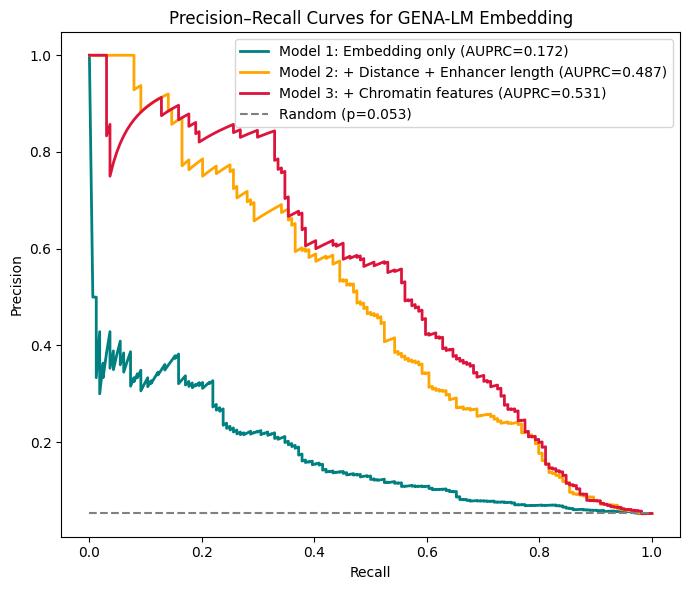

In [20]:
for embedding_extractor in [embedding_extractor_genalm]: #, embedding_extractor_caduceus
    EP_pair_identification(df.copy(), embedding_extractor, feature_sets)

Mistral
  Model 1: Embedding only:
  Precision: 0.217
  Recall   : 0.232
  F1 score : 0.224

Mistral
  Model 2: + Distance + Enhancer length:
  Precision: 0.304
  Recall   : 0.616
  F1 score : 0.407

Mistral
  Model 3: + Chromatin features:
  Precision: 0.287
  Recall   : 0.713
  F1 score : 0.410



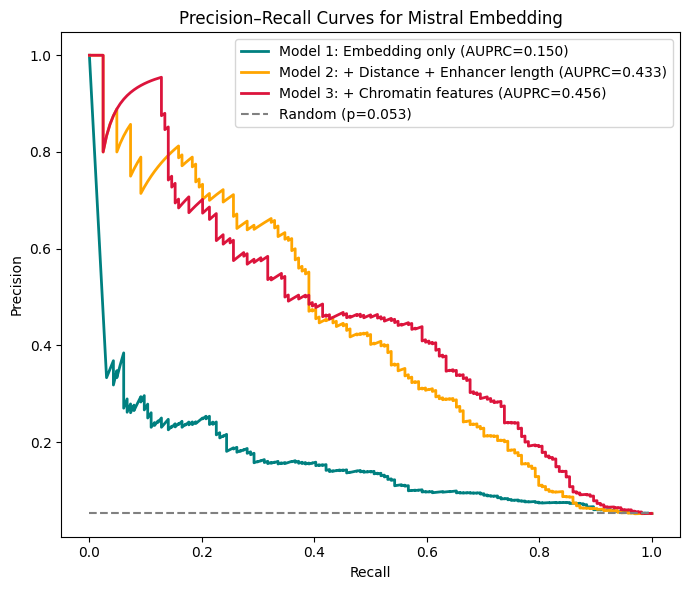

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.10 GiB. GPU 0 has a total capacity of 22.16 GiB of which 3.50 GiB is free. Process 10862 has 18.66 GiB memory in use. Of the allocated memory 16.89 GiB is allocated by PyTorch, and 1.55 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [6]:
for embedding_extractor in [embedding_extractor_mistral, embedding_extractor_genalm]: #, embedding_extractor_caduceus
    EP_pair_identification(df.copy(), embedding_extractor, feature_sets)

HyenaDNA
  Model 1: Embedding only:
  Precision: 0.111
  Recall   : 0.396
  F1 score : 0.174

HyenaDNA
  Model 2: + Distance + Enhancer length:
  Precision: 0.260
  Recall   : 0.720
  F1 score : 0.382

HyenaDNA
  Model 3: + Chromatin features:
  Precision: 0.273
  Recall   : 0.701
  F1 score : 0.393



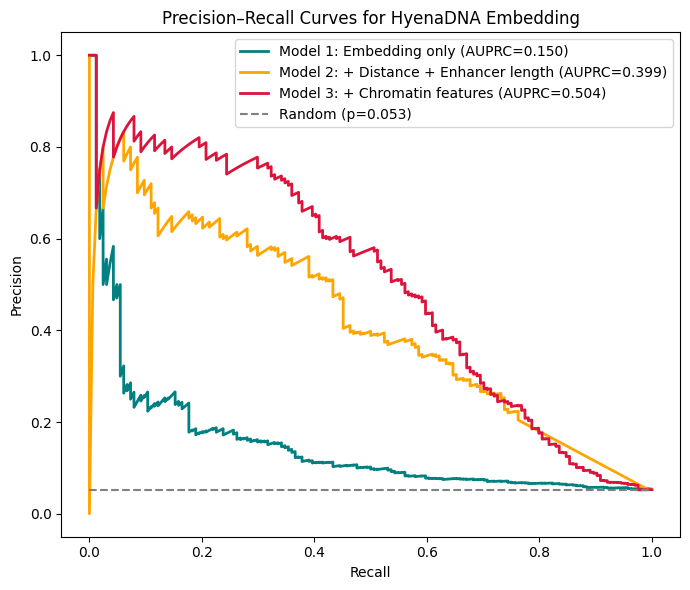

DNABERT2
  Model 1: Embedding only:
  Precision: 0.267
  Recall   : 0.341
  F1 score : 0.299

DNABERT2
  Model 2: + Distance + Enhancer length:
  Precision: 0.242
  Recall   : 0.646
  F1 score : 0.352

DNABERT2
  Model 3: + Chromatin features:
  Precision: 0.274
  Recall   : 0.720
  F1 score : 0.397



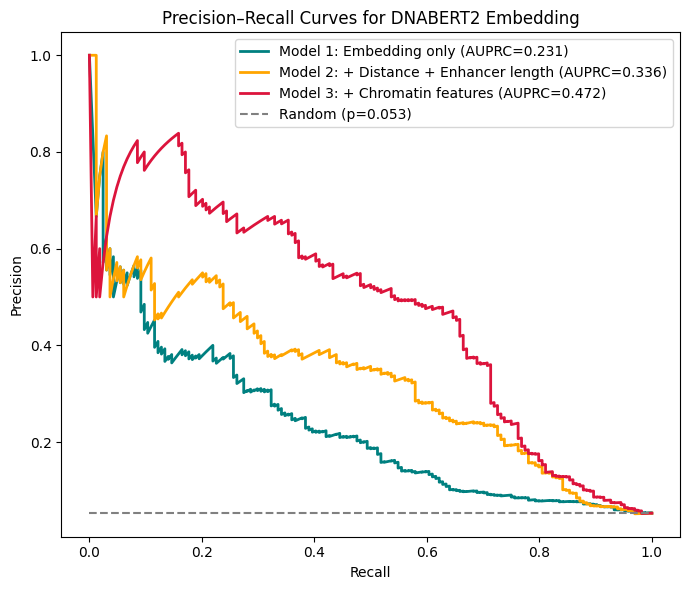

Nucleotide Transformer
  Model 1: Embedding only:
  Precision: 0.221
  Recall   : 0.220
  F1 score : 0.220

Nucleotide Transformer
  Model 2: + Distance + Enhancer length:
  Precision: 0.242
  Recall   : 0.707
  F1 score : 0.360

Nucleotide Transformer
  Model 3: + Chromatin features:
  Precision: 0.315
  Recall   : 0.701
  F1 score : 0.435



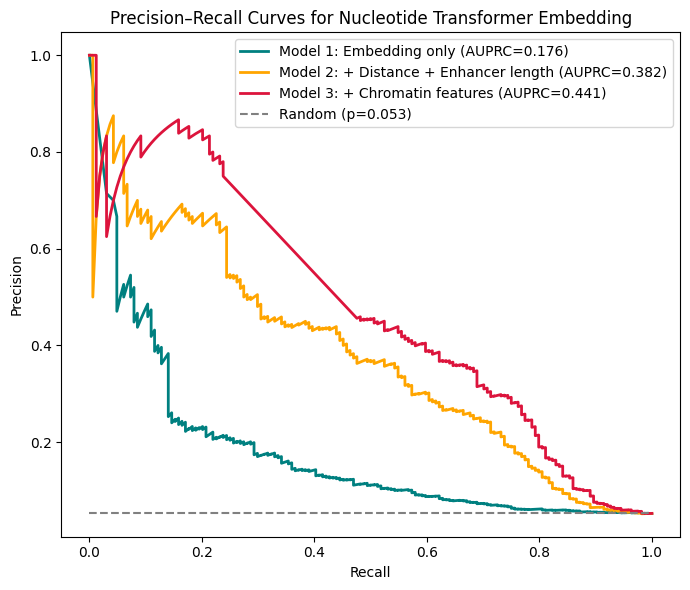

In [ ]:
for embedding_extractor in [embedding_extractor_hyenaDNA, embedding_extractor_dnabert2, embedding_extractor_nt]:
    EP_pair_identification(df.copy(), embedding_extractor, feature_sets)


In [21]:
from google.colab import runtime

runtime.unassign()